In [4]:
import pandas as pd
print(pd.read_csv("Building_Permits.csv", nrows=0).columns.tolist())


['Permit Number', 'Permit Type', 'Permit Type Definition', 'Permit Creation Date', 'Block', 'Lot', 'Street Number', 'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit', 'Unit Suffix', 'Description', 'Current Status', 'Current Status Date', 'Filed Date', 'Issued Date', 'Completed Date', 'First Construction Document Date', 'Structural Notification', 'Number of Existing Stories', 'Number of Proposed Stories', 'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost', 'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units', 'Plansets', 'TIDF Compliance', 'Existing Occupancy', 'Proposed Occupancy', 'Existing Construction Type', 'Existing Construction Type Description', 'Proposed Construction Type', 'Proposed Construction Type Description', 'Site Permit', 'supervisor_district', 'Last Permit Activity Date', 'neighborhoods_analysis_boundaries', 'Zipcode', 'Application Submission Method', 'Location', 'ADU', 'Record ID', 'Primary Address Flag', '

In [5]:
import pandas as pd
import re
from pathlib import Path

csv_path = Path("Building_Permits.csv")  # <-- update to your file

# 1) Read WITHOUT parse_dates first
df = pd.read_csv(csv_path, low_memory=False)

# 2) Normalize headers: lowercase, trim, replace spaces/punct with underscores
def normalize_col(c):
    c = c.strip().lower()
    c = re.sub(r"[^\w]+", "_", c)  # non-alphanumeric -> underscore
    c = re.sub(r"_+", "_", c).strip("_")
    return c

df.columns = [normalize_col(c) for c in df.columns]

print("First 10 normalized columns:")
print(df.columns[:10].tolist())

# 3) Map likely variants -> target names
# Add any additional aliases you see in your file
aliases = {
    "filed_date": {"filed_date", "application_filed_date", "date_filed", "filed_on"},
    "issued_date": {"issued_date", "date_issued", "permit_issued_date"},
    "completed_date": {"completed_date", "finaled_date", "date_completed", "completed_on"}
}

# Build a rename map based on what's actually present
rename_map = {}
for target, candidates in aliases.items():
    for cand in candidates:
        if cand in df.columns:
            rename_map[cand] = target
            break

df = df.rename(columns=rename_map)

# 4) Convert to datetime if present
for c in ["filed_date", "issued_date", "completed_date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

print("\nFound/renamed date columns:", [c for c in ["filed_date","issued_date","completed_date"] if c in df.columns])
print(df.dtypes.head(12))
df.head(3)


First 10 normalized columns:
['permit_number', 'permit_type', 'permit_type_definition', 'permit_creation_date', 'block', 'lot', 'street_number', 'street_number_suffix', 'street_name', 'street_suffix']


/var/folders/wj/cy1skv9928x53xsvh8c4xh7h0000gn/T/ipykernel_2829/924158655.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
/var/folders/wj/cy1skv9928x53xsvh8c4xh7h0000gn/T/ipykernel_2829/924158655.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")



Found/renamed date columns: ['filed_date', 'issued_date', 'completed_date']
permit_number              object
permit_type                 int64
permit_type_definition     object
permit_creation_date       object
block                      object
lot                        object
street_number               int64
street_number_suffix       object
street_name                object
street_suffix              object
unit                      float64
unit_suffix                object
dtype: object


,permit_number,permit_type,permit_type_definition,permit_creation_date,block,lot,street_number,street_number_suffix,street_name,street_suffix,...,neighborhoods_analysis_boundaries,zipcode,application_submission_method,location,adu,record_id,primary_address_flag,point_source,data_as_of,data_loaded_at
0,202511038819,8,otc alterations permit,2025/11/03 10:42:33 PM,7052,037,26,NaN,Thrift,St,...,Oceanview/Merced/Ingleside,94112.0,website,POINT (-122.455000499 37.717734459),N,1735436219282,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
1,202511038818,8,otc alterations permit,2025/11/03 10:25:59 PM,7086,038,166,NaN,Vernon,St,...,Oceanview/Merced/Ingleside,94132.0,website,POINT (-122.467733363 37.715511061),N,1735435220819,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
2,202511038817,8,otc alterations permit,2025/11/03 08:15:32 PM,6778,025,1785,NaN,San Jose,Av,...,Outer Mission,94112.0,website,POINT (-122.439361055 37.728999545),N,1735434212888,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM


In [6]:
# Paths — update these to your local files
DATA_PATH = "Building_Permits.csv"  # or "data/building_permits.csv"
SAVE_DIR = "artifacts"

import os
os.makedirs(SAVE_DIR, exist_ok=True)

import pandas as pd
import numpy as np
from dateutil import parser
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


In [7]:
def load_local_dataset(path: str) -> pd.DataFrame:
    if path.lower().endswith(".parquet"):
        return pd.read_parquet(path)
    elif path.lower().endswith(".csv"):
        return pd.read_csv(path, low_memory=False)
    else:
        raise ValueError("Unsupported file type. Use .csv or .parquet")

df_raw = load_local_dataset(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(425572, 51)


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,neighborhoods_analysis_boundaries,Zipcode,Application Submission Method,Location,ADU,Record ID,Primary Address Flag,point_source,data_as_of,data_loaded_at
0,202511038819,8,otc alterations permit,2025/11/03 10:42:33 PM,7052,037,26,NaN,Thrift,St,...,Oceanview/Merced/Ingleside,94112.0,website,POINT (-122.455000499 37.717734459),N,1735436219282,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
1,202511038818,8,otc alterations permit,2025/11/03 10:25:59 PM,7086,038,166,NaN,Vernon,St,...,Oceanview/Merced/Ingleside,94132.0,website,POINT (-122.467733363 37.715511061),N,1735435220819,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
2,202511038817,8,otc alterations permit,2025/11/03 08:15:32 PM,6778,025,1785,NaN,San Jose,Av,...,Outer Mission,94112.0,website,POINT (-122.439361055 37.728999545),N,1735434212888,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
3,S20251103290,9,NaN,2025/11/03 06:21:52 PM,6750,031,141,V,Milton,St,...,Outer Mission,94112.0,website,POINT (-122.429074081 37.732677722),N,1735433212078,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
4,202511038815,8,otc alterations permit,2025/11/03 04:00:51 PM,1377,038,130,NaN,18th,Av,...,Outer Richmond,94121.0,website,POINT (-122.477270954 37.785452113),N,173543197492,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM


In [8]:
df = df_raw.copy()

# Standardize known column names (handle case variations)
rename_map = {
    "Permit Number":"permit_number",
    "Permit Type":"permit_type",
    "Permit Type Definition":"permit_type_definition",
    "Status":"status",
    "Filed Date":"filed_date",
    "Issued Date":"issued_date",
    "Completed Date":"completed_date",
    "Existing Use":"existing_use",
    "Proposed Use":"proposed_use",
    "Description":"description",
    "Estimated Cost":"estimated_cost",
    "Revised Cost":"revised_cost",
    "Plansets":"plansets",
    "Street Number":"street_number",
    "Street Name":"street_name",
    "Street Suffix":"street_suffix",
    "Zipcode":"zipcode",
    "Supervisor District":"supervisor_district",
    "Neighborhoods - Analysis Boundaries":"neighborhoods_analysis_boundaries"
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# Parse dates
def to_dt(x):
    try:
        return parser.parse(str(x))
    except Exception:
        return pd.NaT

for c in ["filed_date","issued_date","completed_date"]:
    if c in df.columns:
        df[c] = df[c].apply(to_dt)

# Numerics
for c in ["estimated_cost","revised_cost","plansets","supervisor_district","zipcode"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Lowercase selected text cols
for c in ["permit_type_definition","status","existing_use","proposed_use","description","neighborhoods_analysis_boundaries"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

df.head()


,permit_number,permit_type,permit_type_definition,Permit Creation Date,Block,Lot,street_number,Street Number Suffix,street_name,street_suffix,...,neighborhoods_analysis_boundaries,zipcode,Application Submission Method,Location,ADU,Record ID,Primary Address Flag,point_source,data_as_of,data_loaded_at
0,202511038819,8,otc alterations permit,2025/11/03 10:42:33 PM,7052,037,26,NaN,Thrift,St,...,oceanview/merced/ingleside,94112.0,website,POINT (-122.455000499 37.717734459),N,1735436219282,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
1,202511038818,8,otc alterations permit,2025/11/03 10:25:59 PM,7086,038,166,NaN,Vernon,St,...,oceanview/merced/ingleside,94132.0,website,POINT (-122.467733363 37.715511061),N,1735435220819,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
2,202511038817,8,otc alterations permit,2025/11/03 08:15:32 PM,6778,025,1785,NaN,San Jose,Av,...,outer mission,94112.0,website,POINT (-122.439361055 37.728999545),N,1735434212888,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
3,S20251103290,9,nan,2025/11/03 06:21:52 PM,6750,031,141,V,Milton,St,...,outer mission,94112.0,website,POINT (-122.429074081 37.732677722),N,1735433212078,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM
4,202511038815,8,otc alterations permit,2025/11/03 04:00:51 PM,1377,038,130,NaN,18th,Av,...,outer richmond,94121.0,website,POINT (-122.477270954 37.785452113),N,173543197492,Y,eas_address_point,2025/11/04 01:05:01 AM,2025/11/04 04:47:13 AM


In [9]:
print("Rows:", len(df))
print("Date coverage (filed → issued → completed):")
for c in ["filed_date","issued_date","completed_date"]:
    if c in df.columns:
        print(c, df[c].notna().mean())

print("\nPermit types (top 10):")
if "permit_type" in df.columns:
    print(df["permit_type"].value_counts(dropna=False).head(10))

print("\nStatus (top 10):")
if "status" in df.columns:
    print(df["status"].value_counts(dropna=False).head(10))


Rows: 425572
Date coverage (filed → issued → completed):
filed_date 0.9986888235128251
issued_date 0.9346174090400684
completed_date 0.5910727209496865

Permit types (top 10):
permit_type
8    384051
3     29609
4      6639
2      1678
6      1326
7      1047
1       787
9       261
5       174
Name: count, dtype: int64

Status (top 10):


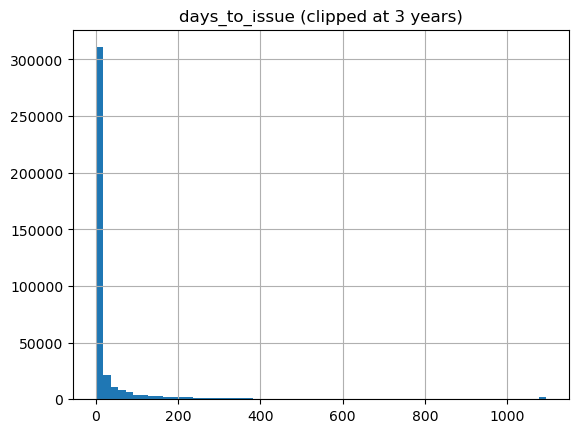

In [10]:
df["days_to_issue"] = (df["issued_date"] - df["filed_date"]).dt.days
df["days_to_complete"] = (df["completed_date"] - df["issued_date"]).dt.days

# Quick distribution glance (optional)
ax = df["days_to_issue"].dropna().clip(0, 365*3).hist(bins=60)
ax.set_title("days_to_issue (clipped at 3 years)")
plt.show()


In [11]:
# Keep rows with needed fields
eligible = df.dropna(subset=["permit_type","days_to_issue"]).copy()

# Compute type-specific 75th percentile threshold
thr = (eligible.groupby("permit_type")["days_to_issue"]
       .quantile(0.75).rename("issue_p75").reset_index())

df = df.merge(thr, on="permit_type", how="left")
df["delayed_issue"] = (df["days_to_issue"] > df["issue_p75"]).astype("Int64")

df["delayed_issue"].value_counts(dropna=False)


delayed_issue
0    329323
1     96249
Name: count, dtype: Int64

In [12]:
covid_cut = pd.Timestamp("2020-03-01")
df["pre_covid"]  = (df["filed_date"] < covid_cut).astype("Int64")
df["post_covid"] = (df["filed_date"] >= covid_cut).astype("Int64")

df["log_estimated_cost"] = np.log1p(df.get("estimated_cost", pd.Series(index=df.index)))

medical_terms = ["clinic","hospital","medical","urgent care","pharmacy","health","dental"]
def is_medical(text):
    t = str(text).lower()
    return int(any(k in t for k in medical_terms))
df["is_medical"] = df.get("description", "").apply(is_medical).astype("Int64")

df[["days_to_issue","issue_p75","delayed_issue","log_estimated_cost","pre_covid","post_covid","is_medical"]].head()


,days_to_issue,issue_p75,delayed_issue,log_estimated_cost,pre_covid,post_covid,is_medical
0,0.0,6.0,0,9.305741,0,1,0
1,0.0,6.0,0,9.159152,0,1,0
2,0.0,6.0,0,9.998843,0,1,0
3,NaN,22.0,0,9.615872,0,0,0
4,0.0,6.0,0,10.043293,0,1,0


In [14]:
# Require filed_date & label
mod = df.dropna(subset=["filed_date","delayed_issue"]).copy()

# Time-based split: first 80% (by filed_date) for train, last 20% for validation
cut_date = mod["filed_date"].quantile(0.80)
train_mask = mod["filed_date"] < cut_date
valid_mask = mod["filed_date"] >= cut_date

print("Train rows:", train_mask.sum(), "Valid rows:", valid_mask.sum())


Train rows: 340011 Valid rows: 85003


In [18]:
from sklearn.impute import SimpleImputer

# Choose features (adjust if columns absent)
cat_candidates = [
    "permit_type","status","proposed_use",
    "neighborhoods_analysis_boundaries","supervisor_district","zipcode"
]
cat_cols = [c for c in cat_candidates if c in mod.columns]

num_cols = ["log_estimated_cost","pre_covid","post_covid","is_medical"]
num_cols = [c for c in num_cols if c in mod.columns]

X = mod[cat_cols + num_cols].copy()
y = mod["delayed_issue"].astype(int)

# Pipelines: impute → encode/ passthrough
cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", dtype=np.float32))
])
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

ct = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe, num_cols),
    ],
    remainder="drop"
)

X_train = X.loc[train_mask]
X_valid = X.loc[valid_mask]
y_train = y.loc[train_mask]
y_valid = y.loc[valid_mask]

X_train.shape, X_valid.shape


((340011, 9), (85003, 9))

In [19]:
# Fit the preprocessor and check the transformed matrices for NaNs
Xt_train = ct.fit_transform(X_train)
Xt_valid = ct.transform(X_valid)

import numpy as np
print("Any NaN in Xt_train?", np.isnan(Xt_train).any())
print("Any NaN in Xt_valid?", np.isnan(Xt_valid).any())


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [20]:
logit_clf = Pipeline(steps=[
    ("prep", ct),
    ("clf", LogisticRegression(max_iter=500))
])

logit_clf.fit(X_train, y_train)
proba_lr = logit_clf.predict_proba(X_valid)[:,1]
auc_lr = roc_auc_score(y_valid, proba_lr)
print("Validation AUC (Logistic):", round(auc_lr, 3))


Validation AUC (Logistic): 0.629


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ("prep", ct),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_clf.fit(X_train, y_train)
proba_gb = gb_clf.predict_proba(X_valid)[:,1]
auc_gb = roc_auc_score(y_valid, proba_gb)
print("Validation AUC (GradientBoosting):", round(auc_gb, 3))


Validation AUC (GradientBoosting): 0.694


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = Pipeline(steps=[
    ("prep", ct),  # imputation still fine; HGB can also handle NaNs if you ever bypass imputation
    ("clf", HistGradientBoostingClassifier(random_state=42))
])

hgb_clf.fit(X_train, y_train)
proba_gb = hgb_clf.predict_proba(X_valid)[:,1]
auc_gb = roc_auc_score(y_valid, proba_gb)
print("Validation AUC (HistGradientBoosting):", round(auc_gb, 3))


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.